Script that generates ensemble files of the output of running CMIP6_light.py and
of the tos temperature files. These files are to be used to calculate the growth potential
of eggs under temperature, light and uv-b changed conditions

Trond Kristiansen 05.10.2021, 29.11.2021

In [21]:
import xarray as xr
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('default')
import os
warnings.simplefilter('ignore') # filter some warning messages
sns.axes_style("whitegrid")

import datetime
import logging

import xarray as xr
import matplotlib as mpl
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
import global_land_mask
import xesmf as xe
import iris

import sys
sys.path.append("../Farallon/QIN/CMIP6-downscale/")
sys.path.append("../Farallon/QIN/CMIP6-downscale/isimip3basd/")
from dateutil.relativedelta import relativedelta
from CMIP6_plot import CMIP6_GLORYS12_plot
from cartopy.util import add_cyclic_point
from CMIP6_model import CMIP6_MODEL
import CMIP6_downscale_iris

In [22]:
# Global variables
par_threshold = 0.0368
depth = 5 # meter
attenuation = 0.18

In [23]:
def convert_to_180(ds):
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:

        time_objects = ds.indexes['time'].to_datetimeindex()
        ds=ds.assign_coords({"time": time_objects})
        ds = xr.decode_cf(ds)

    return ds

def xr_add_cyclic_point(da):
    """
    Inputs
    da: xr.DataArray with dimensions (time,lat,lon)
    """

    # Use add_cyclic_point to interpolate input data
    lon_idx = 2 #da.dims.index('lon')

    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon, axis=lon_idx)

    # Generate output DataArray with new data but same structure as input
    outp_da = xr.DataArray(data=wrap_data,
                           coords = {'time': da.time, 'lat': da.lat, 'lon': wrap_lon},
                           dims=da.dims,
                           attrs=da.attrs)

    return outp_da

def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)

    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)

    return xr.DataArray(mask_data, coords={'lat': lat, 'lon': lon},
                        dims=['lat', 'lon'])

def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def create_ensemble_files(scenarios, var_names):
    # Create ensembles if not already present

    lightpath="../oceanography/light/ncfiles/"
    lightpath="../../../Downloads/"
    ensemble_path="../oceanography/light/ncfiles/ensemble/"
    if not os.path.exists(ensemble_path):
        os.makedirs(ensemble_path, exist_ok=True)

    for var_name in var_names:

        for scenario in scenarios:
            ds_list=[]
            if var_name not in ["_tos.nc", "_siconc.nc"]:
                ensemble_stats=ensemble_path+"{}ensemble_{}.nc".format(var_name, scenario)
            else:
                if var_name=="_tos.nc":
                    ensemble_stats=ensemble_path+"tos_ensemble_{}.nc".format(scenario)
                elif var_name=="_siconc.nc":
                    ensemble_stats=ensemble_path+"siconc_ensemble_{}.nc".format(scenario)

            if os.path.exists(ensemble_stats):
                os.remove(ensemble_stats)

            for f in os.listdir(lightpath):
                print(f, var_name)
                if ((f.startswith(var_name) and scenario in f and "ensemble" not in f) or
                    (f.endswith(var_name) and scenario in f and "ensemble" not in f)):
                    if var_name not in ["uv_srf"] and not f.startswith("uv_srf"):
                        print("{} - {}: found {}".format(var_name, scenario, f))

                        ds=xr.open_dataset(lightpath+f)

                        ds_list.append(ds)
            print("Creating ensemble for {} and scenario {}".format(var_name, scenario))
            ens = ensembles.create_ensemble(ds_list) #.load()
            ens_stats = ensembles.ensemble_mean_std_max_min(ens)

            ens_stats.to_netcdf(ensemble_stats)
            print("Created ensemble {}".format(ensemble_stats))

def create_LME_figure(ax, LMES, projection, show, extent,data_to_contour=None):

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    ax.set_extent(extent)

    # Get the -180-180 projected shapefile containing LMEs to make it
    # easy to plot across the Pacific Ocean
    shdf = get_LME_records_plot()
    colors_rgb=create_colors(len(LMES))
    counter=0
    for LME_NAME,LME_NUMBER in zip(shdf['LME_NAME'],shdf['LME_NUMBER']):

        shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]

        if (LME_NAME in LMES):
           # print("Adding geometry for LME {}".format(LME_NAME))
            # Add the geometry and fill it with color
            if len(LMES)==1:
                color="red"
            else:
                color=colors_rgb[counter]
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor=color,
                              edgecolor='k',
                              zorder=8)
            if data_to_contour is not None:

                ax.contourf(data_to_contour.lon,
                            data_to_contour.lat,
                            data_to_contour,
                            zorder=10,
                   cmap=sns.color_palette("Spectral_r", as_cmap=True),
                   transform=ccrs.PlateCarree())

            # Add the label LME_NUMBER of the selected LME at the center of the LME
          #  ax.annotate(s=LME_NUMBER,
          #              xy=(shdf_sel.centroid.x,shdf_sel.centroid.y),
          #              color="white",
          #              fontsize=13)
            counter+=1
        else:
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor='LightGray',
                              edgecolor='k')

    if show:
        plotfile="Figures/CMIP6_lightpaper_map_{}.png".format(LMES[0])
        print("Created figure {}".format(plotfile))
        plt.savefig(plotfile, dpi=200,
                        bbox_inches = 'tight')
        plt.show()

def get_data_within_LME(ds,var_name,LME,create_maps, scenario):

    print("Extracting data within LME {} for {} scenario {}".format(LME, var_name, scenario))

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Create the map of the LME boundaries and color it.
    # The active LME has color while the others are grey.
    if create_maps:
        # Setup the figure panels
        fig = plt.figure(figsize=(13, 8))
        if LME in ["Barents Sea","Arctic Ocean"]:
            projection=ccrs.NorthPolarStereo() #ccrs.PlateCarree(central_longitude=0)
            extent = [-8, 80, 67, 90]
        else:
            projection=ccrs.PlateCarree(central_longitude=-180)
            extent = [-252, -100, 10, 65]
            extent = [-220, -135, 30, 85]
        ax1 = fig.add_subplot(111, projection=projection)

        create_LME_figure(ax1, [LME], ccrs.PlateCarree(central_longitude=-180),True,extent)

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.

    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'}) #.to_dataset()

    return clipped


def get_formatted_ds_within_LME(ds, var_name, LME, scenario):
    if var_name in ["tos_mean","siconc_mean"]:
        ds=ds.assign_coords(lat=ds.y, lon=ds.x)
        ds=ds.rename({"x":"lon","y":"lat"})
    ds = convert_to_180(ds)
    ds = convert_time(ds)

    ds_lme = get_data_within_LME(ds, var_name, LME, False, scenario)
    ds_lme = xr_add_cyclic_point(ds_lme[var_name])
    ds_lme = ds_lme.to_dataset(name=var_name)

    # Add land mask
    ds_lme["mask"] = create_land_ocean_mask(ds_lme.isel(time=0))
    return ds_lme.where(ds_lme.mask == 1)

def calculate_daily_uvb_exposure_and_combine_datasets(ds, ds_uvb, ds_par):
    # Sum up the four UVB values per day to get daily exposure (kJm-2)
    ds[uvb_var] = (ds_uvb[uvb_var] * 3600*4.0)/1000.
    ds[par_var] = ds_par[par_var]

    return ds.resample(time="MS", skipna=True).sum()


def egg_survival(ds:xr.Dataset, var_name:str, species:str, growth_or_survival:str):
    """Calculate egg survival in surface for different species in percentage given
    temperature of water column """

    ds["par_mean"]=ds["par_mean"]*np.exp(-depth*attenuation)
    ds["areacello_par_masked"]= xr.where(ds["par_mean"] >= par_threshold, ds["areacello"], np.nan)
    ds["tos_mean_par_masked"]= xr.where(ds["par_mean"] >= par_threshold, ds["tos_mean"], np.nan)

    for specie in species:
        print("Calculating survival for {}".format(specie))
        T = ds["tos_mean"]
        if specie == "pacific_cod":
            # Laurel et al., 2020
            H = (0.453 / (1 + ((T - 4.192) / 2.125)**2)) * 100
        elif specie == "atlantic_cod":
            # Dahlke et al., 2018
            H = -318027.1388 + (318119.8195 / (1 + ((T-4.337) /  467.4799)**2))
        elif specie == "polar_cod":
            # Laurel et al., 2018
            H = 87.926 + 1.266*T - 3.6582*T**2
        elif specie=="walleye_pollock":
            # Laurel et al., 2018
            H=72.127+5.775*T - 0.801*T**2
        H =xr.where(H < 0, 0.0, H)

        ds["{}_{}_par_masked".format(specie, growth_or_survival)]=(('time', 'lat', 'lon'),  H.data)
    return ds

def calculate_areacello(ds, model_obj, var_name, project_name):

        # Calculate the area based on the longitude - latitude
        if ds.lon.ndim == 2:
            lon = ds.lon.values[0, :]
            lat = ds.lat.values[:, 0]
        else:
            lon = ds.lon.values
            lat = ds.lat.values

        ds_singletime = ds.isel(time=0)

        # Convert the dataset to a cube as this adds correct units required by iris
        sdiris = CMIP6_downscale_iris.CMIP6_downscale_iris()
        cube = sdiris.ds_to_iris(ds_singletime,
                                 var_name,
                                 model_obj,
                                 project_name, prefix="cube")

        # Calculate the areacello for the grid and convert the result to km2
        # Uses iris area_weights function.
        # https://scitools.org.uk/iris/docs/v2.4.0/iris/iris/analysis/cartography.html#iris.analysis.cartography.area_weights
        m2_to_km2 = 1.0e-6
        area_ends = (iris.analysis.cartography.area_weights(cube, normalize=False)) * m2_to_km2

        # Now convert the numpy array of areas to a dataset with the same dimension as the siconc
        area_ds = xr.DataArray(name="areacello",
                               data=area_ends,
                               coords={"lat": lat,
                                       "lon": lon},
                               dims=["lat", "lon"]).to_dataset()

        # Convert the resulting dataset to an iris cube
        area_cube = sdiris.ds_to_iris(area_ds,
                                      "areacello",
                                      model_obj,
                                      project_name,
                                      prefix="areacello_")

        # Fix the coordinates so that we add geographic information to the cube,
        # before saving the cube to the siconc dataset
        area_cube = sdiris.fix_coordinates_cube(area_cube)

        return xr.DataArray.from_iris(area_cube)



def cumulative_larval_growth_potential(ds:xr.Dataset, var_name:str, species:str, growth_or_survival:str):
    """Calculate larval survival in surface for different species in percentage given
    temperature of water column"""

    ds_daily = ds.resample(time="1D", skipna=True).interpolate('linear')
    ds_daily["par_mean"]=ds_daily["par_mean"]*np.exp(-depth*attenuation)

    ds_daily["tos_mean"]= xr.where(ds_daily["par_mean"] >= par_threshold, ds_daily["tos_mean"], np.nan)
    ds_daily["areacello_par_masked"]= xr.where(ds_daily["par_mean"] >= par_threshold, ds_daily["areacello"], np.nan)
    ds_daily["tos_mean_par_masked"]= xr.where(ds_daily["par_mean"] >= par_threshold, ds_daily["tos_mean"], np.nan)

    ds_daily=ds_daily.transpose("time","lat","lon")

    print("total sum 1 : {}".format(ds_daily["tos_mean"].count(dim=["lat","lon"]).sum().values))
    print("total sum 2 : {}".format(ds_daily["tos_mean_par_masked"].count(dim=["lat","lon"]).sum().values))

    for specie in species:
        print("Calculating growth potential for {}".format(specie))
        T = ds_daily[var_name]
        T_par = ds_daily["tos_mean_par_masked"]

        if specie == "atlantic_cod":
            # Bjørnsson et al., 2007
            G = -0.2425 + 0.1519 * T + 0.0552*T**2 - 0.002931*T**3
            G_par = -0.2425 + 0.1519 * T_par + 0.0552*T_par**2 - 0.002931*T_par**3
        elif specie == "polar_cod":
            # Laurel et al., 2016
            G = 0.8290 + 0.1638 * T - 0.0054* T**2 - 0.0005 * T**3
            G_par = 0.8290 + 0.1638 * T_par - 0.0054* T_par**2 - 0.0005 * T_par**3

        ds_daily["{}_{}".format(specie, growth_or_survival)]=(('time', 'lat', 'lon'),  G.data)
        ds_daily["{}_{}_par_masked".format(specie, growth_or_survival)]=(('time', 'lat', 'lon'),  G_par.data)

    return ds_daily.resample(time="MS", skipna=True).mean()



def calculate_combined_uvb_scaled_survival_and_combine_datasets(ds:xr.Dataset,
                                                                ds_uvb_lme:xr.Dataset,
                                                                ds_sic_lme:xr.Dataset,
                                                                ds_par_lme:xr.Dataset,
                                                                species:str,
                                                                seaice_minimum:int):

    regridder = xe.Regridder(ds_uvb_lme,ds, "bilinear",
                                             periodic=False,
                                             extrap_method='inverse_dist',
                                             extrap_num_src_pnts=2,
                                             extrap_dist_exponent=1,
                                             ignore_degenerate=True)

    regridder_sic = xe.Regridder(ds_sic_lme,ds, "bilinear",
                                             periodic=False,
                                             extrap_method='inverse_dist',
                                             extrap_num_src_pnts=2,
                                             extrap_dist_exponent=1,
                                             ignore_degenerate=True)

    ds[uvb_var]=(('time', 'lat', 'lon'), regridder(ds_uvb_lme[uvb_var]).data)
    ds[par_var]=(('time', 'lat', 'lon'), regridder(ds_par_lme[par_var]).data)
    ds["siconc_mean"]=(('time', 'lat', 'lon'), regridder_sic(ds_sic_lme["siconc_mean"]).data)

    """
    Filter out only areas where minimum light threshold is adequate for feeding. any other regions will
    not satisfy survival for larval stages.
    """
    ds[uvb_var]= xr.where(ds["par_mean"] >= par_threshold, ds[uvb_var], np.nan)
    ds[par_var]= xr.where(ds["par_mean"] >= par_threshold, ds[par_var], np.nan)

    """
    Calculate the monthly relative change in uvb light for the LMe and provide as timeseries
    """
    clim_uvb = ds[uvb_var].sel(time=(slice("1980-01-01","2000-12-31"))).groupby("time.month").mean(dim="time")
    clim_par = ds[par_var].sel(time=(slice("1980-01-01","2000-12-31"))).groupby("time.month").mean(dim="time")

    ds["uvb_ice"] = (ds[uvb_var].groupby("time.month") - clim_uvb)/clim_uvb.max(dim="month")
    ds["par_ice"] = (ds[par_var].groupby("time.month") - clim_par)/clim_par.max(dim="month")

    #xr.where(((ds["siconc_mean"] > seaice_minimum) ), ds[uvb_var], np.nan)
   # ds["uvb_ice"]=xr.where(((np.isnan(ds["siconc_mean"]) | (ds["siconc_mean"] == 0.0))), ds["uvb_ice"], np.nan)
   # ds["par_ice"]=xr.where(((np.isnan(ds["siconc_mean"]) | (ds["siconc_mean"] == 0.0))), ds["par_ice"], np.nan)

    return ds


def q10(x):
    return x.quantile(0.1)
def q90(x):
    return x.quantile(0.9)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
def q5(x):
    return x.quantile(0.05)
def q95(x):
    return x.quantile(0.95)

def plot_averaged_growth_or_survival(df:pd.DataFrame,
                                     df_survival:pd.DataFrame,
                                     specie:[str],
                                     rolling_mean_years:int,
                                     egg_or_larva:str):

    # This plotting method takes the SSP245 and SSP585 dataframe for survival/growth, temperature,
    # and uvb light and plots each of these variables. Dataframe is in monthly values but an aggregator
    # function calculates the annual average mean and quantiles within each year fulfilling the months requirement.
    # For larval and juvenile stages we consider only the summer months e.g. months=[5,6,7,8]

    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)
    f=plt.figure(figsize=(12, 12))
    f.clf()

    gs = f.add_gridspec(1, 3)
    ax = f.add_subplot(gs[0, 1])
    ax2 = f.add_subplot(gs[0, 2])
    ax3 = f.add_subplot(gs[0, 0])

    sns.set_palette("tab10")

    # Organize the data for dataframe survival --------
    df_survival["time_bin"] = pd.to_datetime(df_survival.time)
    bins=np.arange(1979,2100,1)

    dfs245=df_survival[df_survival["scenario"]=="ssp245"]
    dfs585=df_survival[df_survival["scenario"]=="ssp585"]

    # Growth or survival in areas adequate for feeding
    dfs245['time_bin'] = pd.cut(dfs245.time_bin.dt.year, bins, right=False)
    specie_var="{}_{}_par_masked".format(specie, egg_or_larva)

    dfgs245 = dfs245.groupby('time_bin', as_index=False)[specie_var].agg([q10,q90,q25,q75,q5,q95,"mean"])
    dfgs245["proper_time"]=[datetime.datetime(1980,6,15)+relativedelta(years=i) for i in range(0,120)]

    dfs585['time_bin'] = pd.cut(dfs585.time_bin.dt.year, bins, right=False)
    dfgs585 = dfs585.groupby('time_bin', as_index=False)[specie_var].agg([q10,q90,q25,q75,q5,q95,"mean"])
    dfgs585["proper_time"]=[datetime.datetime(1980,6,15)+relativedelta(years=i) for i in range(0,120)]

    # Areacello where PAR above threshold for feeding
    if egg_or_larva== "egg":
        sel_var = "tos_mean"
    else:
        sel_var = "areacello_par_masked"
    dftos245 = dfs245.groupby('time_bin', as_index=False)[sel_var].agg([q10,q90,q25,q75,q5,q95,"mean"])
    dftos245["proper_time"]=[datetime.datetime(1980,6,15)+relativedelta(years=i) for i in range(0,120)]

    dftos585 = dfs585.groupby('time_bin', as_index=False)[sel_var].agg([q10,q90,q25,q75,q5,q95,"mean"])
    dftos585["proper_time"]=[datetime.datetime(1980,6,15)+relativedelta(years=i) for i in range(0,120)]

    # Ocean UVB under ice - not used as very small values
    dfice245 = dfs245.groupby('time_bin', as_index=False)["uvb_ice"].agg([q10,q90,q25,q75,q5,q95,"mean"])
    dfice245["proper_time"]=[datetime.datetime(1980,6,15)+relativedelta(years=i) for i in range(0,120)]

    dfice585 = dfs585.groupby('time_bin', as_index=False)["uvb_ice"].agg([q10,q90,q25,q75,q5,q95,"mean"])
    dfice585["proper_time"]=[datetime.datetime(1980,6,15)+relativedelta(years=i) for i in range(0,120)]

    alpha=0.2
    tickfontsize=22

    # SSP245 growth/survival
    ax.fill_between(dfgs245['proper_time'],
                    dfgs245['q5'].rolling(rolling_mean_years).mean(),
                    dfgs245['q95'].rolling(rolling_mean_years).mean(),
                    alpha=alpha,color = 'tab:blue')

    ax.plot(dfgs245["proper_time"],
            dfgs245['mean'].rolling(rolling_mean_years).mean(),
            color = 'tab:blue', alpha = 1.0, linewidth = 4)

    # SSP585 growth/survival
    ax.fill_between(dfgs585['proper_time'],
                    dfgs585['q5'].rolling(rolling_mean_years).mean(),
                    dfgs585['q95'].rolling(rolling_mean_years).mean(),
                    alpha=alpha,color = 'tab:orange')

    ax.plot(dfgs585["proper_time"],
            dfgs585['mean'].rolling(rolling_mean_years).mean(),
            color = 'tab:orange', alpha = 1.0, linewidth = 4)

    # SSP245 ocean temperature
    ax3.fill_between(dftos245['proper_time'],
                    dftos245['q5'].rolling(rolling_mean_years).mean(),
                    dftos245['q95'].rolling(rolling_mean_years).mean(),
                    alpha=alpha,
                    color = 'tab:blue')

    ax3.plot(dftos245["proper_time"],
             dftos245['mean'].rolling(rolling_mean_years).mean(),
         #    linestyle="--",
             color = 'tab:blue',
             alpha = 1.0, linewidth = 4)

    # SSP585 TOS
    ax3.fill_between(dftos585['proper_time'],
                    dftos585['q5'].rolling(rolling_mean_years).mean(),
                    dftos585['q95'].rolling(rolling_mean_years).mean(),
                    alpha=alpha,color = 'tab:orange')


    ax3.plot(dfgs585["proper_time"],
             dftos585['mean'].rolling(rolling_mean_years).mean(),
             #linestyle="--",
             color = 'tab:orange',
             alpha = 1.0, linewidth = 4)

    ax4=ax2.twinx()
    """
    SSP245+SSP585 ocean relative changes in UV-B to 1979-1990 monthly averages
    """

    ax4.fill_between(dfice245['proper_time'],
                    dfice245['q5'].rolling(rolling_mean_years).mean(),
                    dfice245['q95'].rolling(rolling_mean_years).mean(),
                    alpha=alpha,
                    color = 'tab:purple')

    ax4.plot(dfice245["proper_time"],
             dfice245['mean'].rolling(rolling_mean_years).mean(),
             linestyle="--",
             color = 'tab:purple',
             alpha = 1.0, linewidth = 2)

    ax4.fill_between(dfice585['proper_time'],
                    dfice585['q5'].rolling(rolling_mean_years).mean(),
                    dfice585['q95'].rolling(rolling_mean_years).mean(),
                    alpha=alpha,color = 'tab:red')


    ax4.plot(dfice585["proper_time"],
             dfice585['mean'].rolling(rolling_mean_years).mean(),
             linestyle="--",
             color = 'tab:red',
             alpha = 1.0, linewidth = 2)

    ax.tick_params(labelsize=tickfontsize)
    ax3.tick_params(labelsize=tickfontsize)
    ax4.tick_params(labelsize=tickfontsize)

    ax.set_ylabel("")
    ax3.set_ylabel("")
    ax4.set_ylabel("")

    ylabels = ['{:,.1%}'.format(y) for y in ax4.get_yticks()]
    ax4.set_yticklabels(ylabels)

    ylabels = ['{:,.1f}{}'.format(y,u"%") for y in ax.get_yticks()]
    ax.set_yticklabels(ylabels)

    ylabels = ['{:.0e}{}'.format(y,u"\N{DEGREE SIGN}C") for y in ax3.get_yticks()]
    if egg_or_larva== "egg":
        ylabels = ['{:,.2f}{}'.format(y,u"\N{DEGREE SIGN}C") for y in ax3.get_yticks()]
    else:
        ylabels = ['{:,.0f}{}'.format(y,u"km$^{2}$") for y in ax3.get_yticks()]
    ax3.set_yticklabels(ylabels)
    plt.legend(loc="upper right", frameon=False, fontsize=24)

    # https://reckoningrisk.com/watercolor-regression/
    df["time_bin"] = pd.to_datetime(df.time)
    df245=df[df["scenario"]=="ssp245"]
    df585=df[df["scenario"]=="ssp585"]

    # Plot PAR for the selected months
    df245['time_bin'] = pd.cut(df245.time_bin.dt.year, bins, right=False)
    dfg245 = df245.groupby('time_bin', as_index=False)["par_ice"].agg([q10,q90,q25,q75,q5,q95,"mean"])
    dfg245["proper_time"]=[datetime.datetime(1980,6,15)+relativedelta(years=i) for i in range(0,120)]

    df585['time_bin'] = pd.cut(df585.time_bin.dt.year, bins, right=False)
    dfg585 = df585.groupby('time_bin', as_index=False)["par_ice"].agg([q10,q90,q25,q75,q5,q95,"mean"])
    dfg585["proper_time"]=[datetime.datetime(1980,6,15)+relativedelta(years=i) for i in range(0,120)]

    ax2.fill_between(dfg245['proper_time'],
                     dfg245['q5'].rolling(rolling_mean_years).mean(),
                     dfg245['q95'].rolling(rolling_mean_years).mean(),
                     alpha=alpha,color = 'tab:blue')

    ax2.plot(dfg245["proper_time"],
                  dfg245['mean'].rolling(rolling_mean_years).mean(),
                  color = 'tab:blue', alpha = 1.0, linewidth = 4)

    ax2.fill_between(dfg585['proper_time'],
                     dfg585['q5'].rolling(rolling_mean_years).mean(),
                     dfg585['q95'].rolling(rolling_mean_years).mean(),
                     alpha=alpha,color = 'tab:orange')

    ax2.plot(dfg585['proper_time'],
             dfg585['mean'].rolling(rolling_mean_years).mean(),
             color = 'tab:orange', alpha = 1.0, linewidth = 4)

    ax2.tick_params(labelsize=tickfontsize)
    ax2.set_ylabel("") #"kJm$^{-2}$", fontsize=24)
    ylabels = ['{:,.1%}'.format(y) for y in ax2.get_yticks()]
    ax2.set_yticklabels(ylabels)
    f.canvas.draw()

    # Before you can edit and rotate the labels you have to draw them
    plt.draw()

    ax.set_xticklabels(ax.get_xticklabels(), rotation=-90, ha='right', fontsize=18)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=-90, ha='right',fontsize=18)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=-90, ha='right',fontsize=18)
    ax.tick_params(labelsize=tickfontsize)
    ax3.tick_params(labelsize=tickfontsize)
    ax2.tick_params(labelsize=tickfontsize)

    if not os.path.exists("Figures"):
        os.makedirs("Figures")
    plotfile="Figures/{}_uvb_{}_{}.png".format(egg_or_larva, LME, specie)
    print("Created figure {}".format(plotfile))
    gs.tight_layout(f)

    plt.savefig(plotfile, dpi=300,
                bbox_inches = 'tight')
    plt.show()


Extracting data within LME Barents Sea for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for tos_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,829,455.39 km2
[create_land_ocean_mask] Running create_land_ocean_mask
Calculating survival for atlantic_cod
Calculating survival for polar_cod
Extracting data within LME Barents Sea for uvb_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for par_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for siconc_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for tos_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,829,455.39 km2
[create_land_ocean_mask] Running create_land_ocean_mask
Calculating survival for atlantic_cod
Calculating survival for polar_cod


Created figure Figures/egg_uvb_Barents Sea_atlantic_cod.png


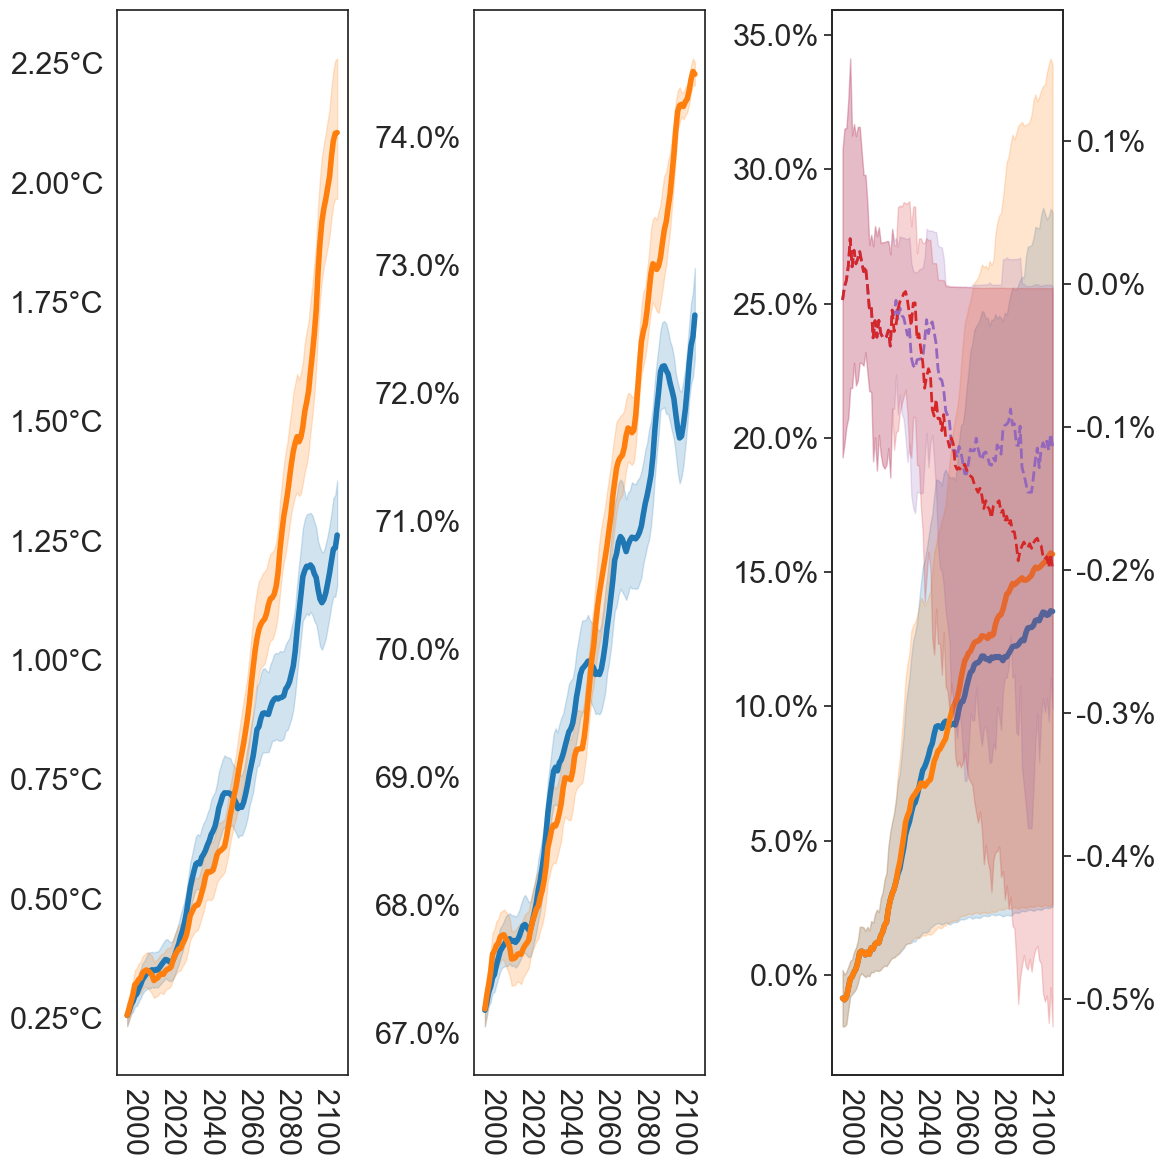

Created figure Figures/egg_uvb_Barents Sea_polar_cod.png


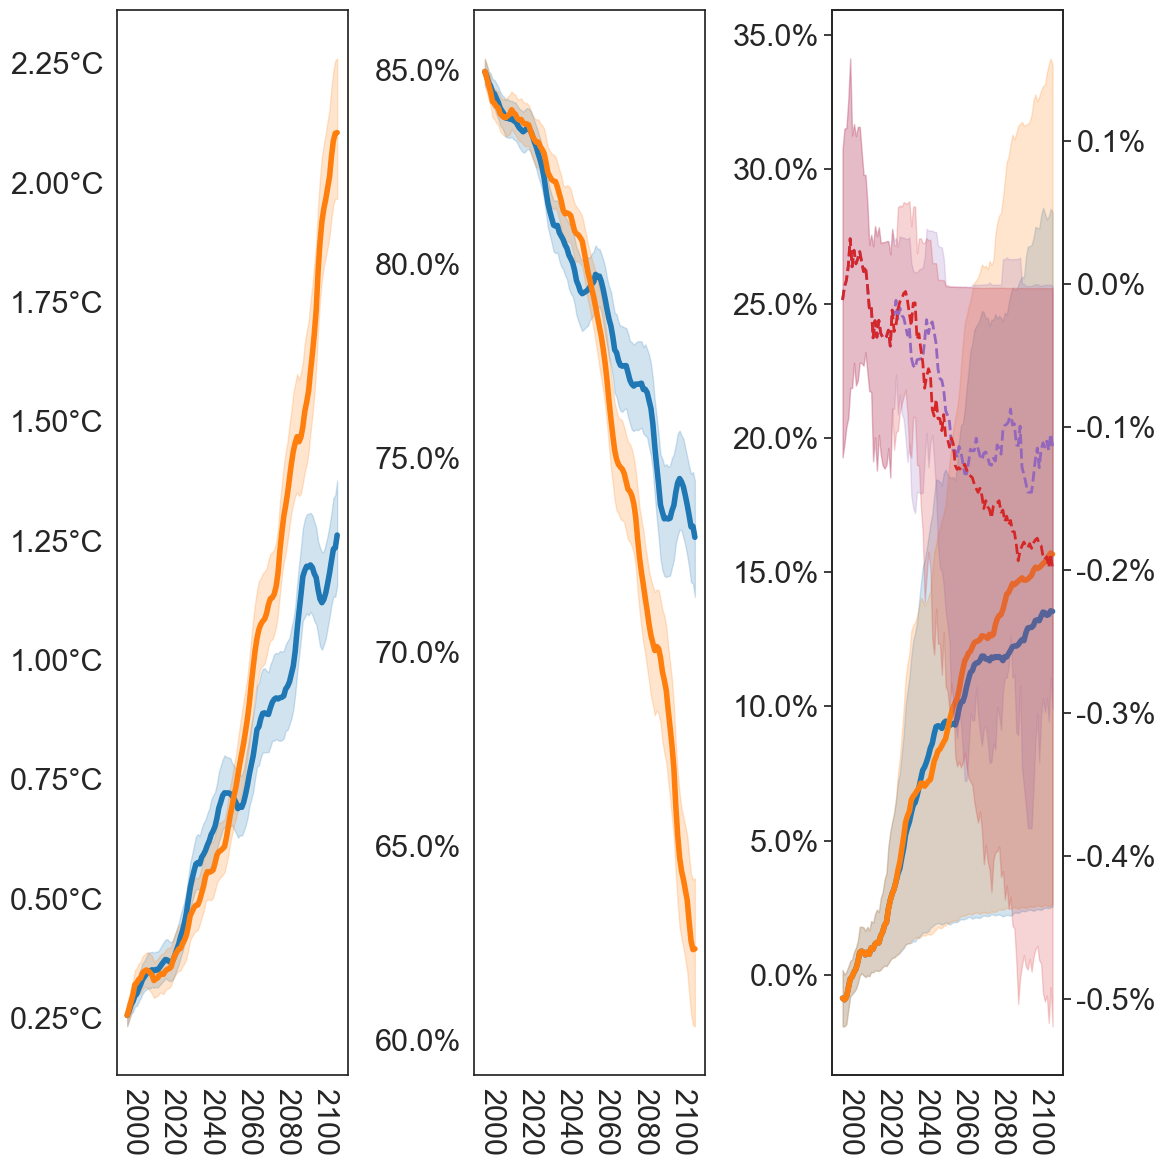

Extracting data within LME East Bering Sea for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for tos_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,298,850.17 km2
[create_land_ocean_mask] Running create_land_ocean_mask
Calculating survival for polar_cod
Extracting data within LME East Bering Sea for uvb_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for par_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for siconc_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for tos_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,298,850.17 km2
[create_land_ocean_mask] Running create_land_ocean_mask
Calculating survival for polar_cod


Created figure Figures/egg_uvb_East Bering Sea_polar_cod.png


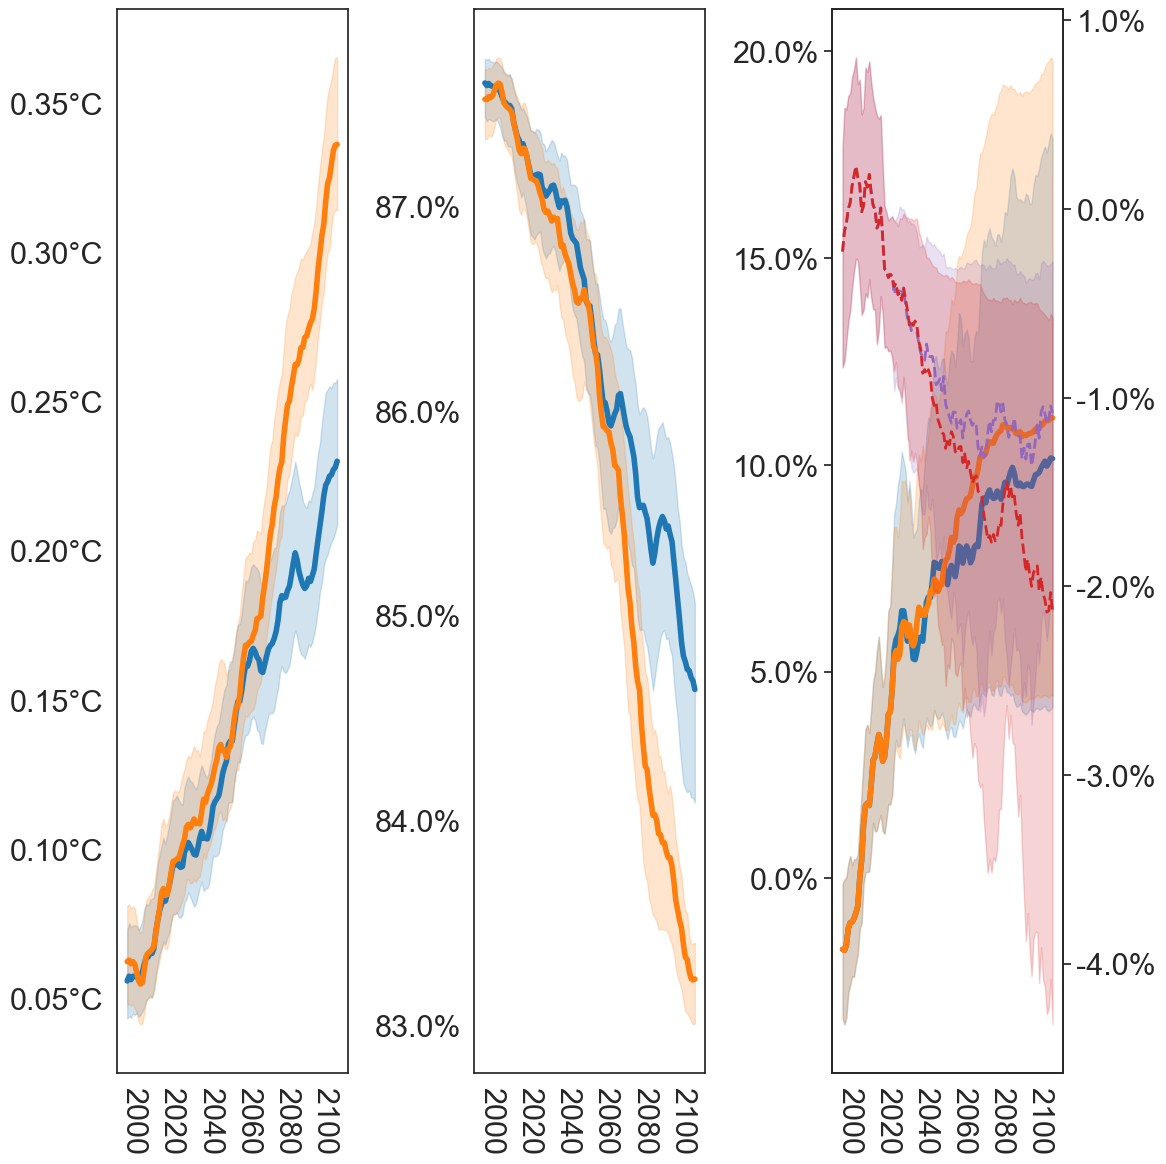

Extracting data within LME Northern Bering - Chukchi Seas for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for tos_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,247,935.24 km2
[create_land_ocean_mask] Running create_land_ocean_mask
Calculating survival for polar_cod
Extracting data within LME Northern Bering - Chukchi Seas for uvb_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for par_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for siconc_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for tos_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,247,935.24 km2
[create_land_ocean_mask] Running create_land_ocean_mask
Calculating survival for polar_cod


Created figure Figures/egg_uvb_Northern Bering - Chukchi Seas_polar_cod.png


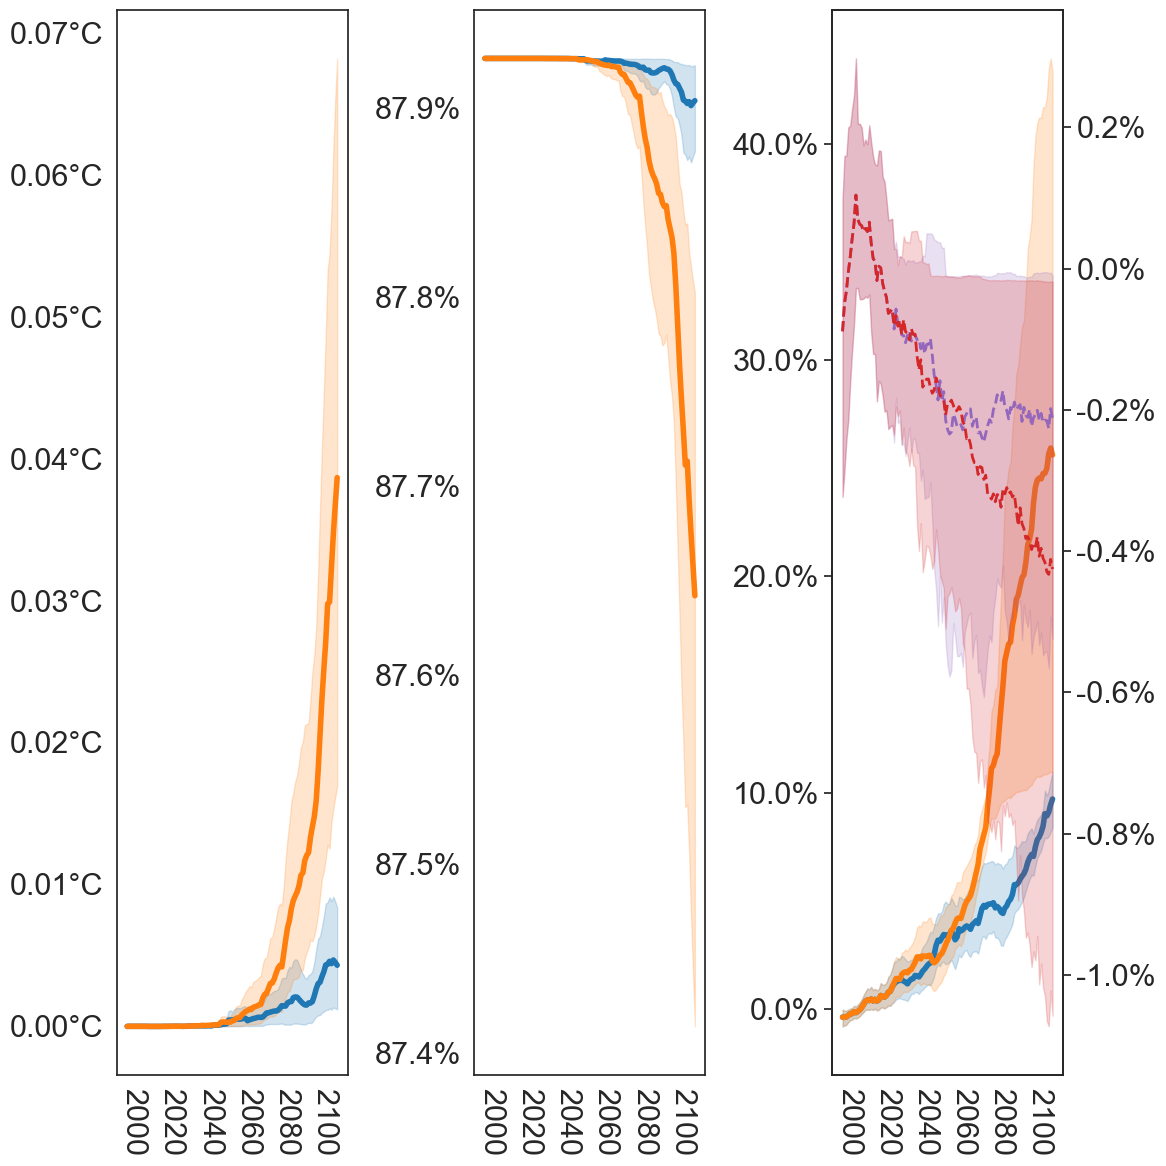

Extracting data within LME Barents Sea for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for tos_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,829,455.39 km2
[create_land_ocean_mask] Running create_land_ocean_mask
total sum 1 : 14046392
total sum 2 : 14046392
Calculating growth potential for atlantic_cod
Calculating growth potential for polar_cod
Extracting data within LME Barents Sea for uvb_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for par_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for siconc_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Barents Sea for tos_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,829,455.39 km2
[create_land_ocean_mask] Running create_land_ocean_mask
total sum 1 : 14063559
total sum 2 : 14063559
Calculating growth potential for atlantic_cod
Calculating growth potential for polar_cod


Created figure Figures/larva_uvb_Barents Sea_atlantic_cod.png


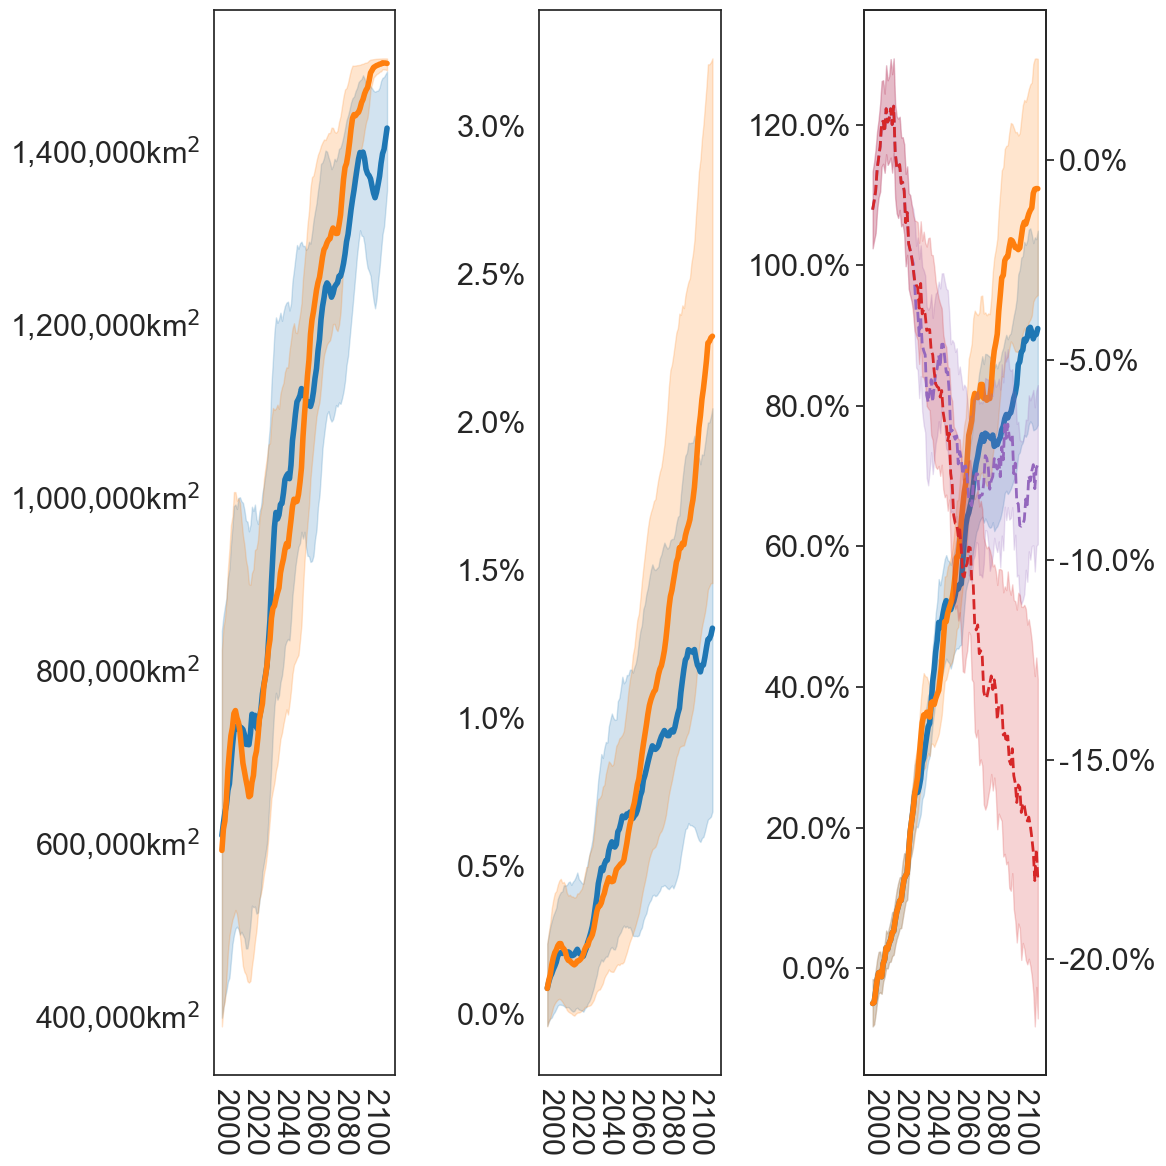

Created figure Figures/larva_uvb_Barents Sea_polar_cod.png


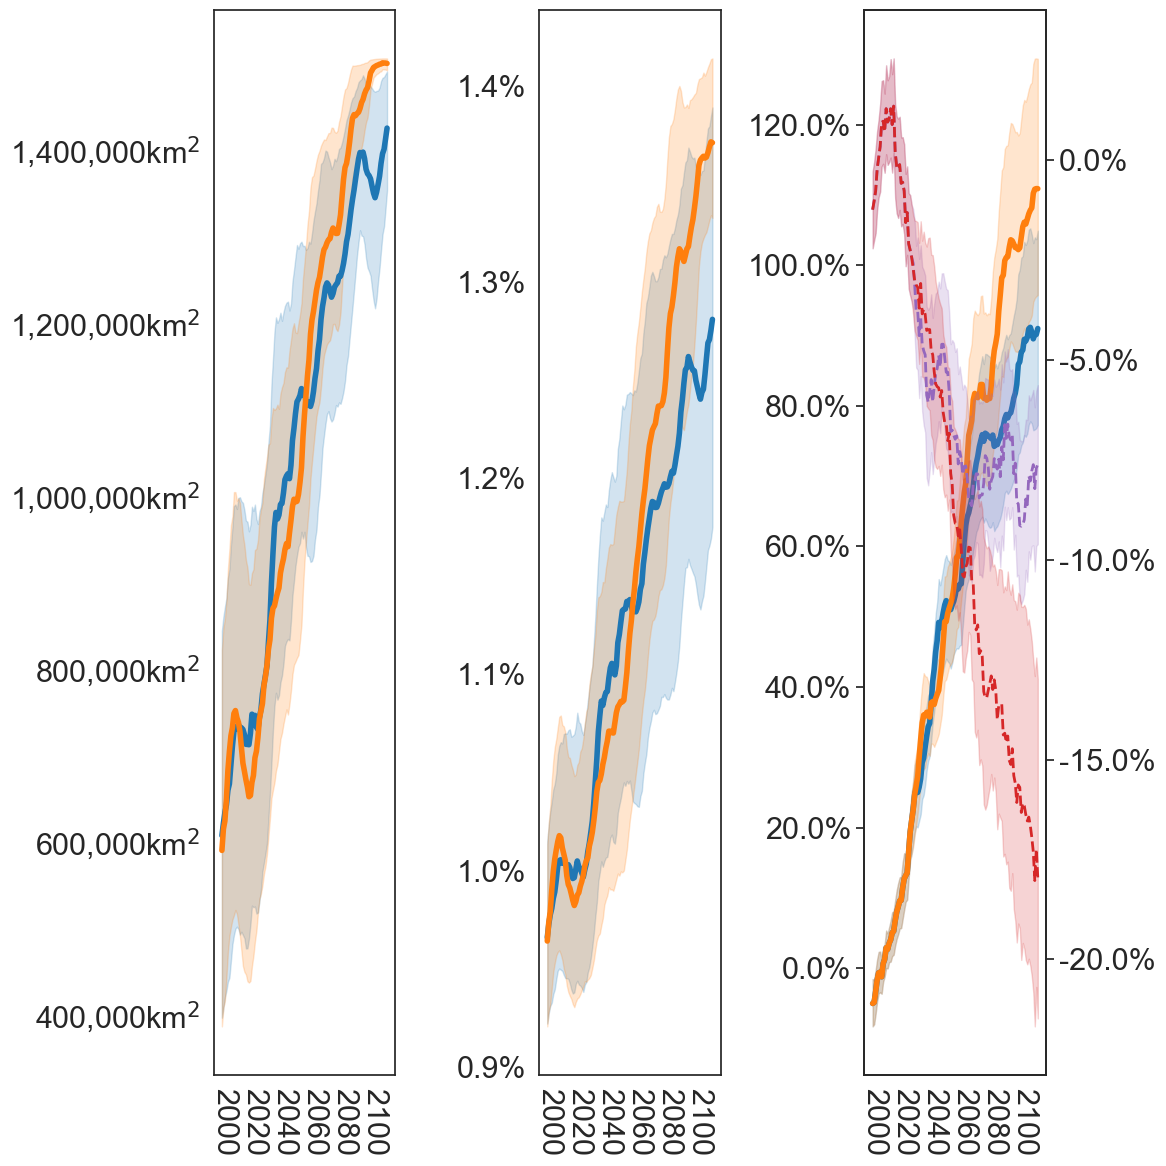

Extracting data within LME East Bering Sea for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for tos_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,298,850.17 km2
[create_land_ocean_mask] Running create_land_ocean_mask
total sum 1 : 6757245
total sum 2 : 6757245
Calculating growth potential for polar_cod
Extracting data within LME East Bering Sea for uvb_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for par_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for siconc_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME East Bering Sea for tos_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,298,850.17 km2
[create_land_ocean_mask] Running create_land_ocean_mask
total sum 1 : 6757245
total sum 2 : 6757245
Calculating growth potential for polar_cod


Created figure Figures/larva_uvb_East Bering Sea_polar_cod.png


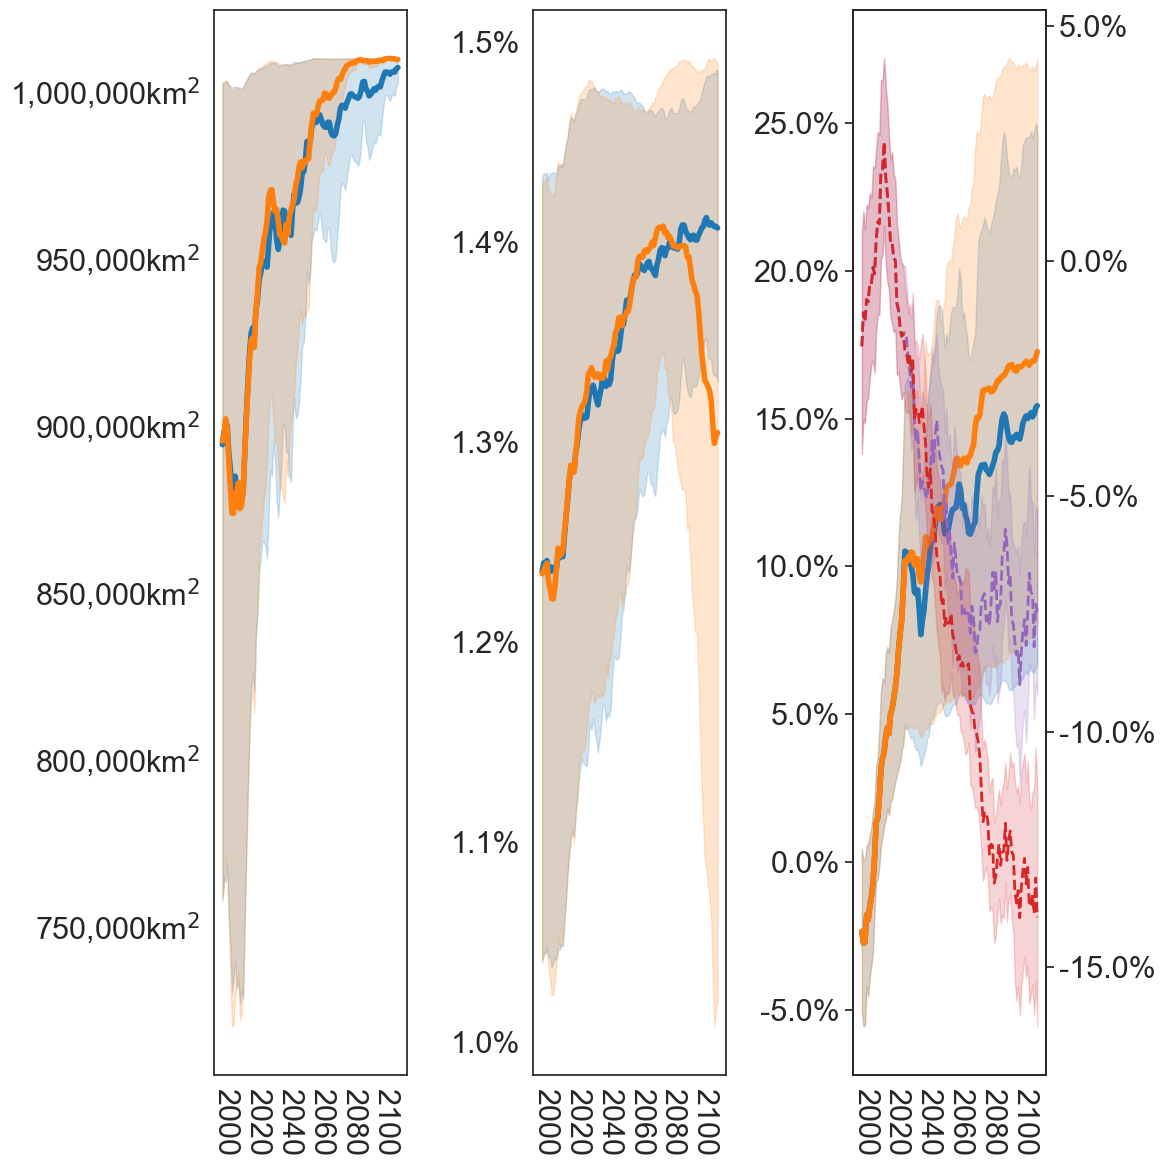

Extracting data within LME Northern Bering - Chukchi Seas for uvb_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for par_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for siconc_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for tos_mean scenario ssp245
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,247,935.24 km2
[create_land_ocean_mask] Running create_land_ocean_mask
total sum 1 : 7787757
total sum 2 : 7787757
Calculating growth potential for polar_cod
Extracting data within LME Northern Bering - Chukchi Seas for uvb_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for par_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for siconc_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask
Extracting data within LME Northern Bering - Chukchi Seas for tos_mean scenario ssp585
[create_land_ocean_mask] Running create_land_ocean_mask


[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 1,247,935.24 km2
[create_land_ocean_mask] Running create_land_ocean_mask
total sum 1 : 7917896
total sum 2 : 7917896
Calculating growth potential for polar_cod


Created figure Figures/larva_uvb_Northern Bering - Chukchi Seas_polar_cod.png


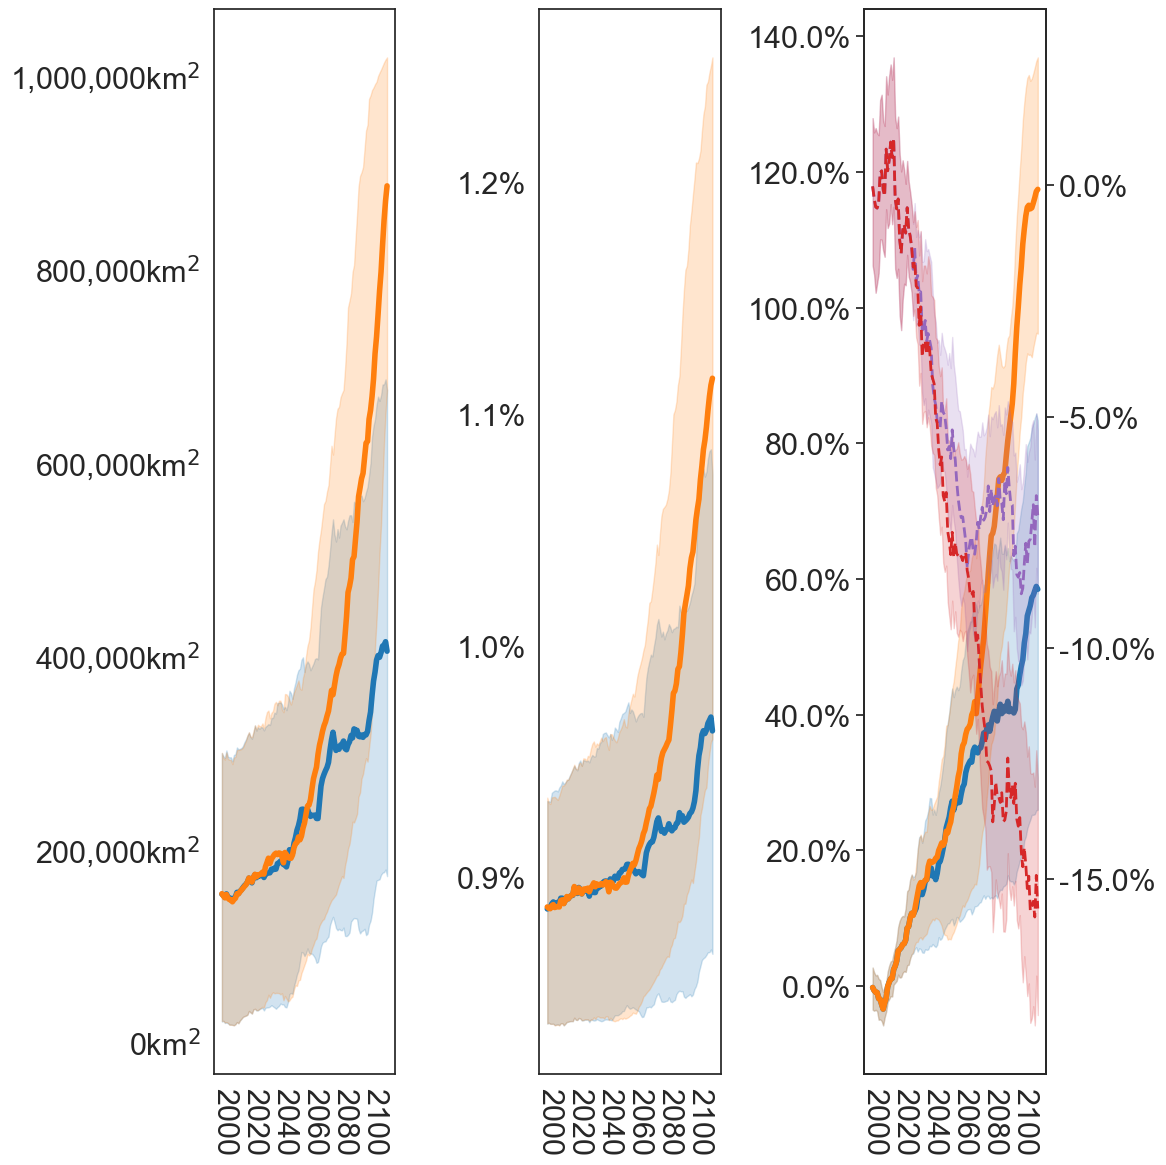

In [24]:
LMES = ['Barents Sea','East Bering Sea','Northern Bering - Chukchi Seas'] #,'Central Arctic']
#, 'Central Arctic', 'East Bering Sea']
SPECIES_PER_LME = [["atlantic_cod","polar_cod"],["polar_cod"],
                   ["polar_cod"],["polar_cod"]]

create_ensemble = False
scenarios=["ssp245","ssp585"]
var_names=["uvb_"] #"uv_","uvi_","par_", "uvb_","_tos.nc","_siconc.nc"]

start_time = "1979-01-01"
end_time = "2099-12-16"
spring_months=[4,5,6]
winter_months=[1,2,3]

rolling_mean_years=10
seaice_minimum=15

if create_ensemble:
    create_ensemble_files(scenarios, var_names)

for months in [winter_months,spring_months]:
    for LME, species in zip(LMES, SPECIES_PER_LME):

        if LME in ["Barents Sea","Arctic Ocean"]:
            projection=ccrs.NorthPolarStereo()
            extent = [-10, 80, 67, 85]
        else:
            projection=ccrs.PlateCarree(central_longitude=-180)
            extent = [-200, -145, 50, 85]

        dfs=[]
        dfs_survival=[]
        uvb_var="uvb_mean"
        par_var="par_mean"

        for scenario in scenarios:

            tos = xr.open_dataset("../oceanography/light/ncfiles/ensemble/tos_ensemble_{}.nc".format(scenario))
            uvb = xr.open_dataset("../oceanography/light/ncfiles/ensemble/uvb_ensemble_{}.nc".format(scenario))
            par = xr.open_dataset("../oceanography/light/ncfiles/ensemble/par_ensemble_{}.nc".format(scenario))
            sic = xr.open_dataset("../oceanography/light/ncfiles/ensemble/siconc_ensemble_{}.nc".format(scenario))

            par = par.sel(time=slice(start_time,end_time))
            tos = tos.sel(time=slice(start_time,end_time))
            uvb = uvb.sel(time=slice(start_time,end_time))
            sic = sic.sel(time=slice(start_time,end_time))

            ds_uvb_lme = get_formatted_ds_within_LME(uvb, uvb_var, LME, scenario)
            ds_par_lme = get_formatted_ds_within_LME(par, par_var, LME, scenario)
            ds_sic_lme = get_formatted_ds_within_LME(sic, "siconc_mean", LME, scenario).resample(time="MS", skipna=True).mean()
            ds_tos_lme = get_formatted_ds_within_LME(tos, "tos_mean", LME, scenario).resample(time="MS", skipna=True).mean()

            ds_sic_lme = xr.where(ds_sic_lme <= 0, np.nan, ds_sic_lme)
            ds_tos_lme = xr.where(ds_tos_lme <= -2.0, np.nan, ds_tos_lme)

            ds_tos_lme = xr.where(((ds_tos_lme < 1.e-20) | (ds_tos_lme > 1e20)), np.nan, ds_tos_lme)
            ds_sic_lme = xr.where(((ds_sic_lme < 1.e-20) | (ds_sic_lme > 1e20)), np.nan, ds_sic_lme)
            ds_par_lme = xr.where(((ds_par_lme < 1.e-20) | (ds_par_lme > 1e20)), np.nan, ds_par_lme)
            ds_uvb_lme = xr.where(((ds_uvb_lme < 1.e-20) | (ds_uvb_lme > 1e20)), np.nan, ds_uvb_lme)

            # Select the time period
            ds_uvb_lme = ds_uvb_lme.sel(lat=slice(50,91))
            ds_par_lme = ds_par_lme.sel(lat=slice(50,91))
            ds_tos_lme = ds_tos_lme.sel(lat=slice(50,91))
            ds_sic_lme = ds_sic_lme.sel(lat=slice(50,91))

            ds_tos_lme["mask"] = create_land_ocean_mask(ds_tos_lme.isel(time=0))
            ds_tos_lme = ds_tos_lme.where(ds_tos_lme.mask == 1)
            model_obj = CMIP6_MODEL("ensemble")

            ds_tos_lme["areacello"] = calculate_areacello(ds_tos_lme, model_obj, "tos_mean", project_name="light")
            # Clip the area to the polygon - this also clips to the time varying var_name# which results in
            # time varying areacello variable that we can use to sum up the size of open water by
            # looking at the annual mean.
            # First we set all areas outside of the polygon to nan - which also now includes
            # areacello which as part of teh calculations actually covered the whole region (and
            # not just the polygon).
            ds_tos_lme = xr.where(np.isnan(ds_tos_lme["tos_mean"]), np.nan, ds_tos_lme)
            total_area_lme = np.nansum(ds_tos_lme["areacello"].mean(dim="time").values)
            print("[calculate_areacello] Average total area {:,.2f} km2".format(total_area_lme))

            ds_uvb_lme = ds_uvb_lme.resample(time="MS", skipna=True).mean()
            ds_sic_lme = ds_sic_lme.resample(time="MS", skipna=True).mean()
            ds_par_lme = ds_par_lme.resample(time="MS", skipna=True).mean()
            ds_uvb_lme["mask"]=(('lat', 'lon'), ds_uvb_lme["mask"].isel(time=0).data)
            ds_sic_lme["mask"]=(('lat', 'lon'), ds_sic_lme["mask"].isel(time=0).data)
            ds_par_lme["mask"]=(('lat', 'lon'), ds_par_lme["mask"].isel(time=0).data)

            ds = calculate_daily_uvb_exposure_and_combine_datasets(ds_tos_lme, ds_uvb_lme, ds_par_lme)

            # Light (par, uvb) and forcing (tos, sic) are on slightly different grids. We combine all
            # datasets to a common grid.
            ds["mask"] = create_land_ocean_mask(ds.isel(time=0))

            ds = calculate_combined_uvb_scaled_survival_and_combine_datasets(ds, ds_uvb_lme, ds_sic_lme, ds_par_lme, species, seaice_minimum)

            # Calculate the survival potential for all species
            if months[0]>=4:
                larva_or_egg= "larva"
                ds = cumulative_larval_growth_potential(ds, "tos_mean", species, larva_or_egg)
            else:
                larva_or_egg= "egg"
                ds = egg_survival(ds, "tos_mean", species, larva_or_egg)

            # Important to set zeros to nan - the zeroes come after performing resample
           # ds = xr.where(ds <= 0, np.nan, ds)

            ds_avg=ds.sel(time=ds.time.dt.month.isin(months)).mean({"lat","lon"})

            ds_avg = ds_avg.assign(areacello_par_masked = ds["areacello_par_masked"].sum({"lat","lon"}))


            df = ds_avg.to_dataframe() #.resample("A").mean()
            df_survival = ds_avg.to_dataframe() #.resample("A").mean()

            df = df.reset_index(level=[0])
            df_survival = df_survival.reset_index(level=[0])

            df["scenario"]=scenario
            df_survival["scenario"]=scenario

            dfs.append(df)
            dfs_survival.append(df_survival)

            outfile = "Figures/{}_ensemble_{}_{}.png".format("tos", scenario, LME)

            plot_clim=False
            if plot_clim:
                for var_name, ds in zip(["tos","uvb"], [ds]):
                    for clim_start_time, clim_end_time in zip(["2050-01-01"],
                                                              ["2060-01-01"]):
                        print("[CMIP6_plot] Creating climatology plot for {} to {}".format(start_time, end_time))

                        cmip6 = CMIP6_GLORYS12_plot()

                        cmip6.plot_monthly_climatology("{}_mean".format(var_name),
                                                       "surface", "0",
                                                       ds,
                                                       "Figures/",
                                                       prefix="light",
                                                       start_time=clim_start_time,
                                                       end_time=clim_end_time,
                                                       delta=False,
                                                       extent=extent,
                                                       projection=projection)

        # Concatenate all scenarios into one dataframe for this LME
        df_all = pd.concat(dfs)
        df_all_survival = pd.concat(dfs_survival)

        # Plot the results for this LME
        for specie in species:
            plot_averaged_growth_or_survival(df_all, df_all_survival, specie, rolling_mean_years,
                                             larva_or_egg)